In [181]:
import numpy as np         
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [182]:
fig_folder = "png"
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

# Data Reading

In [183]:
import pandas as pd

data = pd.read_csv('../data/train.csv')
print(f'The number of datapoints is {data.shape}')
data.head(5)

The number of datapoints is (404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [184]:
data.info()     # display the data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


# Drop Null Data(First Check)


In [185]:
data[data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [186]:
data = data.dropna()            # drop all rows with null values
data.shape

(404287, 6)

# Exploratory Data Analysis

## The distribution of duplicated questions

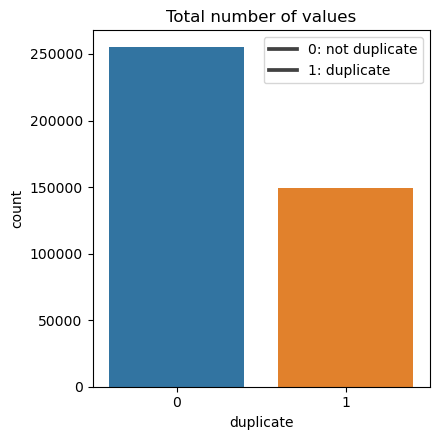

After droping missing values
Total number of question pairs is 404287
Duplicated Questions is 149263, which is 37% of total
Non-Duplicated Questions is 255024, which is 63 % of total


In [187]:
# plotting the number of duplicate pairs and different pairs
plt.figure(figsize=(4.5,4.5))
ct = data['is_duplicate'].value_counts() # count the number of duplicate pairs
sns.barplot(x=ct.index,y=ct.values) # plot the barplot
plt.title('Total number of values')
plt.xlabel('duplicate')
plt.ylabel('count')
plt.legend(['0: not duplicate', '1: duplicate']) 
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'duplicate.png'), dpi=450)
plt.show()

print('After droping missing values')
print('Total number of question pairs is {}'.format(len(data.id.values)))
print('Duplicated Questions is {}, which is {}% of total'.format(ct[1],round((ct[1]/len(data.id.values)*100)),2))
print('Non-Duplicated Questions is {}, which is {} % of total'.format(ct[0],round((ct[0]/len(data.id.values)*100)),2))

In [188]:
ct

0    255024
1    149263
Name: is_duplicate, dtype: int64

## Uniques questions & Repeated questions

In [198]:
# Combine the questions of question1 and question2
total_q= pd.Series(data.question1.tolist() + data.question2.tolist())
print(total_q.head())
unique_q = np.unique(total_q) # Unique questions
num_unique_q = len(unique_q) # Number of unique questions
# Count the number of times each question occured
cnt = total_q.value_counts().sort_values(ascending=False)
once = len(cnt[cnt.values == 1]) # Just once
atleast2 = len(cnt[cnt.values >= 2]) # Atleast 2 times
max_cnt = max(cnt)

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object


In [199]:
print(f'Total questions is {len(total_q)}')
print(f'Unique questions is {num_unique_q}')
print(f'Once: {once}, Atleast2: {atleast2}')
print(num_unique_q == (once + atleast2)) # check the consistency
print(cnt.head()) # Top 5 most occuring questions
print(f"The percentage of quesions that occured more than once is {round((atleast2/num_unique_q)*100,1)}%")
print(f'Max occurance of a question is {max_cnt}') # Max occurance of a question


Total questions is 808574
Unique questions is 537359
Once: 425489, Atleast2: 111870
True
What are the best ways to lose weight?                                             161
How can you look at someone's private Instagram account without following them?    120
How can I lose weight quickly?                                                     111
What's the easiest way to make money online?                                        88
Can you see who views your Instagram?                                               79
dtype: int64
The percentage of quesions that occured more than once is 20.8%
Max occurance of a question is 161


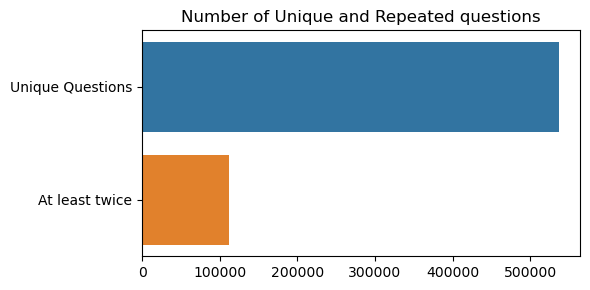

In [200]:
plt.figure(figsize=(6.0,3.0))
qts = pd.Series(data=['Unique Questions','At least twice'], index=[num_unique_q, atleast2])
sns.barplot(x=qts.index, y=qts.values)
plt.title('Number of Unique and Repeated questions')
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'Unique_repeated_quesions.png'), dpi=450)
plt.show()

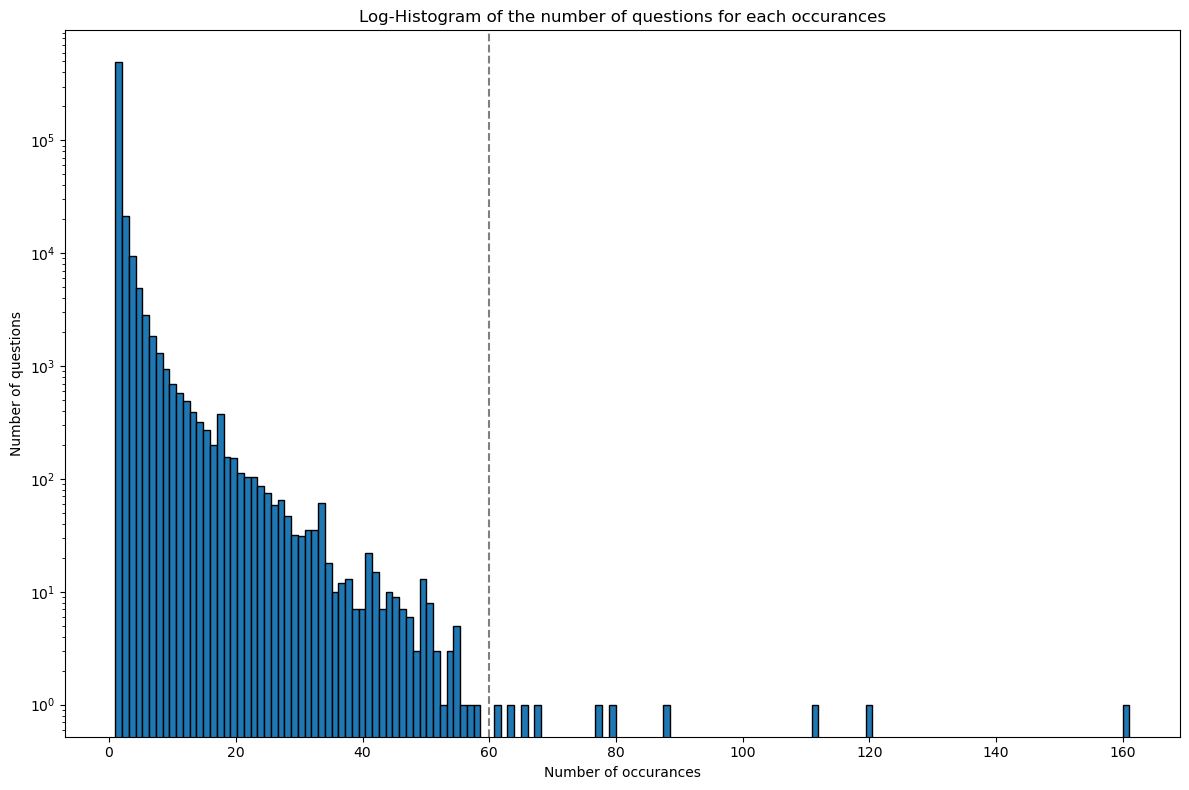

In [208]:
plt.figure(figsize=(12, 8))
plt.hist(cnt,edgecolor='black', bins=150)
plt.axvline(x=60, color='gray', linestyle='--')
plt.yscale('log')
plt.title('Log-Histogram of the number of questions for each occurances')
plt.xlabel('Number of occurances')
plt.ylabel('Number of questions')
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'Log_Histogram_of_question_occurances.png'), dpi=450)
plt.show()

# Feature Engineering

We reconstruct the data and add some new features:
 - ____word_Common____ = (Number of unique common unique words in Question 1 and Question 2) -> The intersection of the two questions
  
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2) -> The union of the two questions
     
 - ____word_share____ = (word_common)/(word_Total), namely the similarity between the two questions. -> The similarity between the two questions


In [808]:
if os.path.isfile('data_after_removing_missing value.csv'):
    data = pd.read_csv("data_after_removing_missing value.csv",encoding='latin-1')
else:
    def common_wrd(row):
        x = set(row['question1'].lower().strip().split(" ")) 
        y = set(row['question2'].lower().strip().split(" "))
        return 1.0 * len(x & y) # intersection of two sets


    def total(row):
        set1 = set(row['question1'].lower().strip().split(" "))
        set2 = set(row['question2'].lower().strip().split(" "))
        return 1.0 * (len(set1) + len(set2)) # union of two sets

    def word_share(row):
        x = row['word_common']/row['word_total']
        return  x # the ratio of common words to total words

data['word_common'] = data.apply(common_wrd,axis=1)
data['word_total'] = data.apply(total,axis=1)
data['word_share'] = data.apply(word_share,axis=1)
# save the data to csv file
data.to_csv("../data/data_after_removing_missing value.csv", index=False)

## New datasheet
As you can see, word_common, word_total, word_share are added to the original dataset.

In [811]:
data = pd.read_csv('../data/data_after_removing_missing value.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,word_common,word_total,word_share
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10.0,23.0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4.0,20.0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,4.0,24.0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.0,19.0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,2.0,20.0,0.100000


### Common words between questions

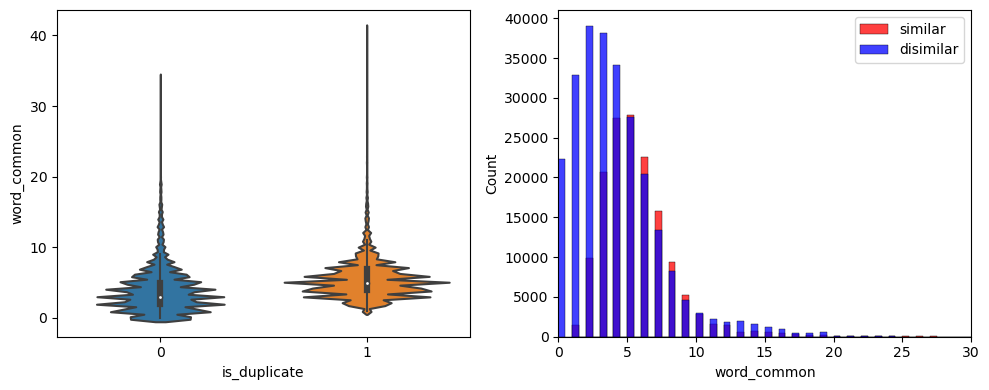

In [812]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=data)
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_common'],color='red',label='similar',binwidth=0.5)
sns.histplot(data[data['is_duplicate'] == 0]['word_common'],color='blue',label='disimilar',binwidth=0.5)
plt.legend()
plt.xlim(0,30)
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_common.png'), dpi=450)
plt.show()

### Shared words
From the following diagram, we can notice that as the word share increases there is a higher chance the questions are similar. From the histogram, we can understand that word share has some information differentiating similar and dissimilar classes. This trend matches the intuition that similar questions will have more words in common.

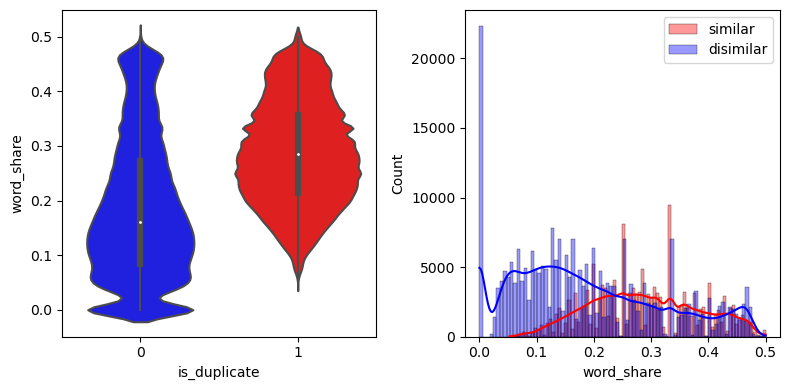

In [813]:
# plotting the relation between dulicate and word_share
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data,palette=['blue','red'])
plt.subplot(1,2,2)
sns.histplot(data[data['is_duplicate'] == 1]['word_share'],alpha = 0.4,color='red',kde=True, label='similar')
sns.histplot(data[data['is_duplicate'] == 0]['word_share'],alpha = 0.4,color='blue',kde=True, label='disimilar')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_share.png'), dpi=450)
plt.show()

### Plotting Word Clouds

Plotting Word Clouds help us to undertand important words/features.

### Text Preprocessing
As a part of text preprocessing, we performed the following steps:

- Removing html tags
- Removing Punctuations
- Performing stemming
- Removing Stopwords
- Expanding contractions etc.

In [814]:
from wordcloud import WordCloud, STOPWORDS
import re
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [815]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  
    
    porter = PorterStemmer()    #apply stemming  for example, "cats" and "catlike" are reduced to "cat"
    pattern = re.compile('\W')  #remove special characters
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

In [816]:
data["question1"] = data["question1"].fillna("").apply(preprocess)
data["question2"] = data["question2"].fillna("").apply(preprocess)

In [817]:
print(data.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   
2   2     5     6  how can i increase the speed of my internet co...   
3   3     7     8  why am i mentally very lonely  how can i solve...   
4   4     9    10  which one dissolve in water quikly sugar  salt...   

                                           question2  is_duplicate  \
0  what is the step by step guide to invest in sh...             0   
1  what would happen if the indian government sto...             0   
2  how can internet speed be increased by hacking...             0   
3  find the remainder when  math 23  24   math  i...             0   
4            which fish would survive in salt water              0   

   word_common  word_total  word_share  
0         10.0        23.0    0.434783  
1          4.0        20.0    0.200000  
2          4.0        2

In [818]:
# save the data to csv file
data.to_csv("../data/data_after_text_preprocessing.csv", index=False)

In [819]:
data_duplicate = data[data['is_duplicate'] == 1]
data_nonduplicate = data[data['is_duplicate'] == 0]

In [820]:
sent_dup =np.dstack([data_duplicate['question1'].values,data_duplicate['question2'].values])
print(sent_dup[0])
print(sent_dup.shape)
# words_dup = [word for sublist in sent_dup for word in sublist]
words_dup = sent_dup.flatten()
print(words_dup[0])
print(words_dup.shape)
sent_ndup =np.dstack((data_nonduplicate['question1'].values,data_nonduplicate['question2'].values))
# words_ndup = [word for sublist in sent_ndup for word in sublist]
words_ndup = sent_ndup.flatten()

[['astrology  i am a capricorn sun cap moon and cap rising   what does that say about me '
  'i am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me ']
 ['how can i be a good geologist '
  'what should i do to be a great geologist ']
 ['how do i read and find my youtube comments '
  'how can i see all my youtube comments ']
 ...
 ['how does a long distance relationship work '
  'how are long distance relationships maintained ']
 ['what does jainism say about homosexuality '
  'what does jainism say about gays and homosexuality ']
 ['do you believe there is life after death '
  'is it true that there is life after death ']]
(1, 149263, 2)
astrology  i am a capricorn sun cap moon and cap rising   what does that say about me 
(298526,)


In [821]:
textp_w = words_dup
textn_w = words_ndup
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

textp_w = [str(i) for i in textp_w]
textn_w = [str(i) for i in textn_w]
print(textn_w[0])
textp_w = ''.join(textp_w)
textn_w = ''.join(textn_w)
print(textn_w[:100])

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510048
what is the step by step guide to invest in share market in india 
what is the step by step guide to invest in share market in india what is the step by step guide to 


### Word cloud for duplicate pair of questions

Word Cloud for Duplicate Question pairs


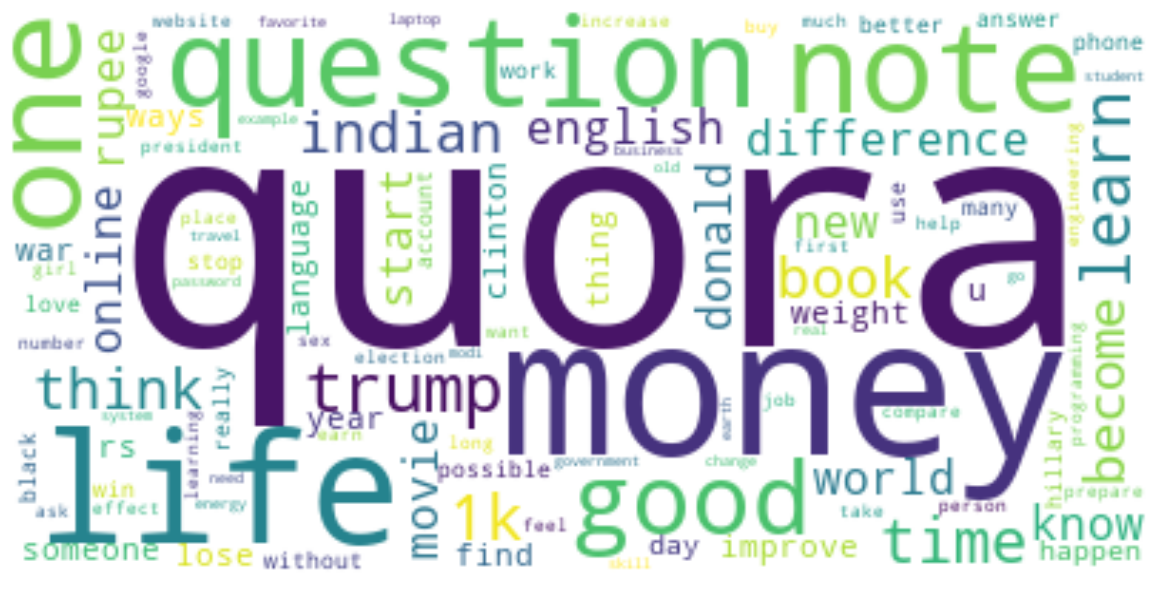

In [824]:
stopwords = set(STOPWORDS)
my_additional_stopwords = ['best','india','will','way','people','make']
stopwords.update(my_additional_stopwords)
wc = WordCloud(background_color="white", max_words= 100, stopwords=stopwords,collocations=False)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_clous_duplicate_pair.png'), dpi=450)
plt.show()

### Word cloud for non duplicate pair of questions

Word Cloud for Non Duplicate Question pairs


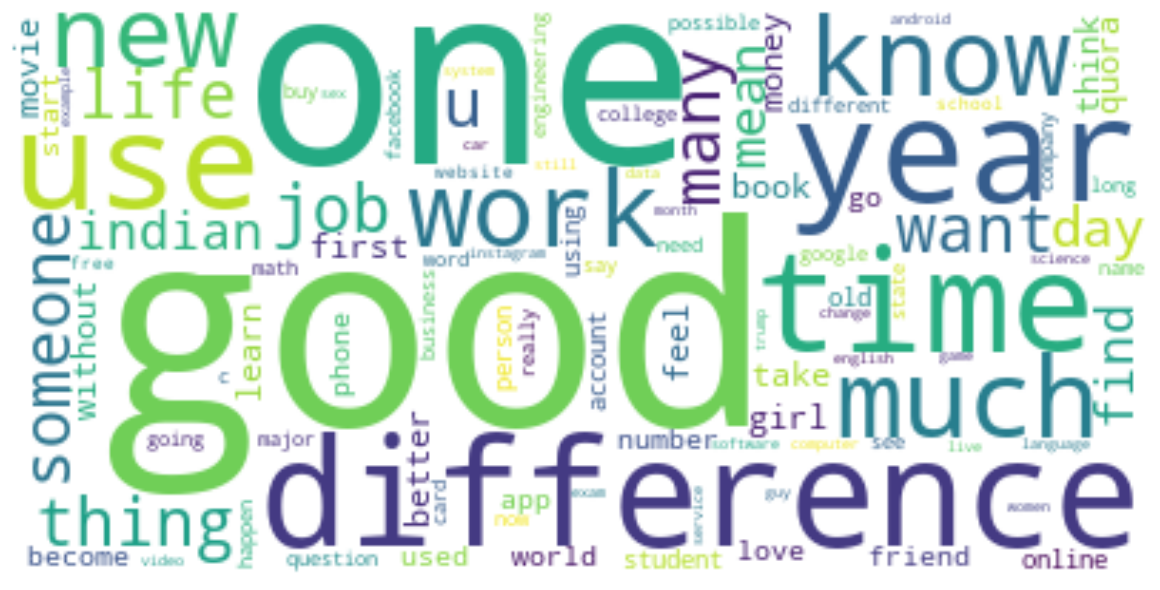

In [825]:
wc = WordCloud(background_color="white", max_words= 100, stopwords=stopwords, collocations=False)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(fig_folder, 'word_clous_non_duplicate_pair.png'), dpi=450)
plt.show()